In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib
import mod_trace

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print('"%s" has been created.'%(path))
    else:
        print("The folder already exists.")

In [3]:
result_dir = './Results'
create_folder(result_dir)

The folder already exists.


In [4]:
class IonModel:
    def __init__(self, name=None, mmt=None, log=None, params=None):        
        super().__init__()
        
        self.name = name
        self.mmt = mmt
        self.log = log
        self.params = params
    
        self.apd = {
            90: 0,
        }    
        
    def __new__(cls, name=None, mmt=None, log=None, params=None):        
        return super().__new__(cls)   

In [5]:
'''
Human Ventricular Cardiomyocytes
'''
import argparse

parser = argparse.ArgumentParser(description='Human Ventricular Cardiomyocytes.')
# parser.add_argument('--epochs',        required=False, default=300,  type=int)
# parser.add_argument('--batch_size',    required=False, default=train_pars.batch_size,  type=int,    help='BATCH SIZE')
# parser.add_argument('--patience',      required=False, default=1000, type=int,    help='patience')
# parser.add_argument('--num_workers',   required=False, default=8,    type=int,    help='num_workers')
# args = parser.parse_args()
args, _ = parser.parse_known_args()
args.mmt_dir_path = "../../../mmt-model-files"
args.cell_types = ['Endocardial', 'Epicardial', 'Mid-myocardial']
args.bcl = 1000
args.duration = 0.5
args.offset = 20

models = {}
models['tenTusscher2004'] = IonModel('tenTusscher2004', "tentusscher-2004.mmt")
models['tenTusscher2004'].log = ["ina.INa", "ito.Ito", "ical.ICaL", "ikr.IKr", "iks.IKs", "ik1.IK1" ]

models['tenTusscher2006'] = IonModel('tenTusscher2006', "tentusscher-2006.mmt")
models['tenTusscher2006'].log = ["ina.INa", "ito.Ito", "ical.ICaL", "ikr.IKr", "iks.IKs", "ik1.IK1" ]

models['ORD2011'] = IonModel('ORD2011', "ord-2011.mmt")
models['ORD2011'].log = ["ina.INa", "ito.Ito", "ical.ICaL", "ikr.IKr", "iks.IKs", "ik1.IK1", "inal.INaL" ]

models['ORD2017'] = IonModel('ORD2017', "newordherg_qNet-v1.mmt")
models['ORD2017'].log = ["ina.INa", "ito.Ito", "ical.ICaL", "ikr.IKr", "iks.IKs", "ik1.IK1", "inal.INaL" ]

models['Tomek2020'] = IonModel('Tomek-2020', "tomek-2020.mmt")
models['Tomek2020'].log = ["INa.INa", "Ito.Ito", "ICaL.ICaL", "IKr.IKr", "IKs.IKs", "IK1.IK1", "INaL.INaL" ]

In [6]:
import simulator_myokit
'''
Simulation with Myokit
'''
start_time = time.time()

protocol = myokit.pacing.blocktrain(args.bcl, args.duration, offset=args.offset) # period, duration, offset=0, level=1.0, limit=0

for model_name, m in models.items():      
    start = time.time()
    
    m_myokit, _, _ = myokit.load(os.path.join(args.mmt_dir_path, m.mmt))
    s_myokit = simulator_myokit.Simulator(m_myokit, protocol, max_step=0.1, abs_tol=1e-08, rel_tol=1e-10, vhold=0)  # 1e-12, 1e-14  # 1e-08, 1e-10
    m.model = m_myokit
    m.sim = s_myokit
    
    print(f"{model_name} --- %s seconds ---"%(time.time()-start))

print("--- %s seconds ---"%(time.time()-start_time))

tenTusscher2004 --- 5.1873719692230225 seconds ---
tenTusscher2006 --- 5.254995584487915 seconds ---
ORD2011 --- 6.176490545272827 seconds ---
ORD2017 --- 6.977325677871704 seconds ---
Tomek2020 --- 6.9720683097839355 seconds ---
--- 30.568252086639404 seconds ---


In [7]:
'''
params for models
'''
args.cell_typeNo = 0
args.end_time = 500

models['tenTusscher2004'].params = {
    'cell.type': args.cell_typeNo,        
}
models['tenTusscher2006'].params = {
    'cell.type': args.cell_typeNo,        
}
models['ORD2011'].params = {
    'cell.mode': args.cell_typeNo,        
}
models['ORD2017'].params = {
    'cell.mode': args.cell_typeNo,        
}
models['Tomek2020'].params = {
    'environment.celltype': args.cell_typeNo,        
}

In [8]:
start_time = time.time()

for model_name, m in models.items():
    print(model_name)
       
    # Pre-pace and set a threshold value for APD measurements
#     m.sim.simulation.reset()     
#     m.sim.pre_simulation.reset()     
#     m.sim.pre_simulation.set_state(m.sim.pre_init_state)
#     m.sim.simulation.set_state(m.sim.pre_init_state)  
    
    m.sim.set_simulation_params(m.params)    
    
    # simulation        
    y0 = m.sim.pre_simulate(args.bcl*30, sim_type=0) 
    vt = 0.9 * m.sim.simulation.state()[m.model.get('membrane.V').indice()]  
    vt_rmp = m.sim.simulation.state()[m.model.get('membrane.V').indice()]
    d = m.sim.simulate(args.end_time, log_times=None, extra_log=m.log, log_interval=0.1)  
        
    APA = abs(vt_rmp - np.max(d['membrane.V'])) #AP amplitude
    threshold_30 = vt_rmp + (0.7 * APA)
    threshold_50 = vt_rmp + (0.5 * APA)
    threshold_70 = vt_rmp + (0.3 * APA)
    threshold_90 = vt_rmp + (0.1 * APA)
    
    apd30 = d.apd(v='membrane.V', threshold=threshold_30)
    m.apd[30] = {
        'start': apd30['start'][0],
        'duration': apd30['duration'][0],
        'vt': threshold_30,      
    }  
    
    apd50 = d.apd(v='membrane.V', threshold=threshold_50)
    m.apd[50] = {
        'start': apd50['start'][0],
        'duration': apd50['duration'][0],
        'vt': threshold_50,      
    }  
    
    apd70 = d.apd(v='membrane.V', threshold=threshold_70)
    m.apd[70] = {
        'start': apd70['start'][0],
        'duration': apd70['duration'][0],
        'vt': threshold_70,      
    }  
    
    apd90 = d.apd(v='membrane.V', threshold = threshold_90)
    m.apd[90] = {
        'start': apd90['start'][0],
        'duration': apd90['duration'][0],
        'vt': threshold_90,      
    }            
    
#     d, apds = m.sim.simulate(args.end_time, log_times=None, extra_log=m.log, apd_variable='membrane.V', apd_threshold=vt)
#     m.apd[90] = {
#         'start': apds['start'][0],
#         'duration': apds['duration'][0],
#         'vt': vt,      
#     } 

    print(f'APD30 for {model_name} = ' + str(apd30['duration'][0]) + ' [ms]')
    print(f'APD50 for {model_name} = ' + str(apd50['duration'][0]) + ' [ms]')
    print(f'APD70 for {model_name} = ' + str(apd70['duration'][0]) + ' [ms]')
    print(f'APD90 for {model_name} = ' + str(apd90['duration'][0]) + ' [ms]')
    
    m.time = np.arange(0, args.end_time, 0.1)#d['engine.time']    
    m.V = d['membrane.V']
    m.I = {}
    
    for l in m.log:
        m.I[l.split('.')[1]] = d[l]
        
    print("-"*100)
print("--- %s seconds ---"%(time.time()-start_time))

tenTusscher2004
APD30 for tenTusscher2004 = 197.7368250809676 [ms]
APD50 for tenTusscher2004 = 241.6348472066013 [ms]
APD70 for tenTusscher2004 = 260.83167306913873 [ms]
APD90 for tenTusscher2004 = 273.9222572605824 [ms]
----------------------------------------------------------------------------------------------------
tenTusscher2006
APD30 for tenTusscher2006 = 237.36785680973884 [ms]
APD50 for tenTusscher2006 = 276.26392493186074 [ms]
APD70 for tenTusscher2006 = 292.921546834977 [ms]
APD90 for tenTusscher2006 = 305.3019241050026 [ms]
----------------------------------------------------------------------------------------------------
ORD2011
APD30 for ORD2011 = 169.75355569500113 [ms]
APD50 for ORD2011 = 210.5228771112014 [ms]
APD70 for ORD2011 = 243.4904753641035 [ms]
APD90 for ORD2011 = 271.10274911512505 [ms]
----------------------------------------------------------------------------------------------------
ORD2017
APD30 for ORD2017 = 170.26217459303618 [ms]
APD50 for ORD2017 = 2

tenTusscher2004
tenTusscher2006
ORD2011
ORD2017
Tomek2020


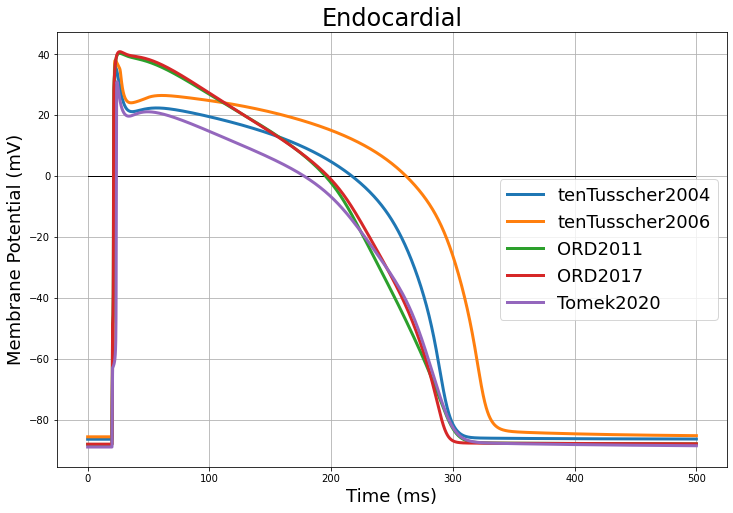

--- 0.3921926021575928 seconds ---


In [9]:
'''
Plot
'''
start_time = time.time()

fig, ax = plt.subplots(1,1, figsize=(12,8))    
ax.plot( np.zeros(args.end_time), linewidth=1, color='k')     
for model_name, m in models.items():
    print(model_name)        
    # fig.suptitle(sim_ohara2017.name, fontsize=14)
    ax.set_title(args.cell_types[args.cell_typeNo], fontsize=24)
    # ax.set_xlim(bdf_m.times.min(), bdf_m.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax.set_ylabel('Membrane Potential (mV)', fontsize=18)  
    ax.set_xlabel('Time (ms)', fontsize=18)       

    ax.plot( m.time, m.V, label=model_name, linewidth=3)         
    # textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(GNa/g_fc[0], \
    #             GNaL/g_fc[1], Gto/g_fc[2], PCa/g_fc[3], GKr/g_fc[4], GKs/g_fc[5], GK1/g_fc[6], Gf/g_fc[7])
    # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    #     ax.text(0.67, 0.60, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)    
    #     fig1 = plt.gcf()
    ax.legend(fontsize=18)
    ax.grid()

plt.show()
fig.savefig(os.path.join(result_dir, f"AP_{args.cell_types[args.cell_typeNo]}.jpg"), dpi=300)    
print("--- %s seconds ---"%(time.time()-start_time))

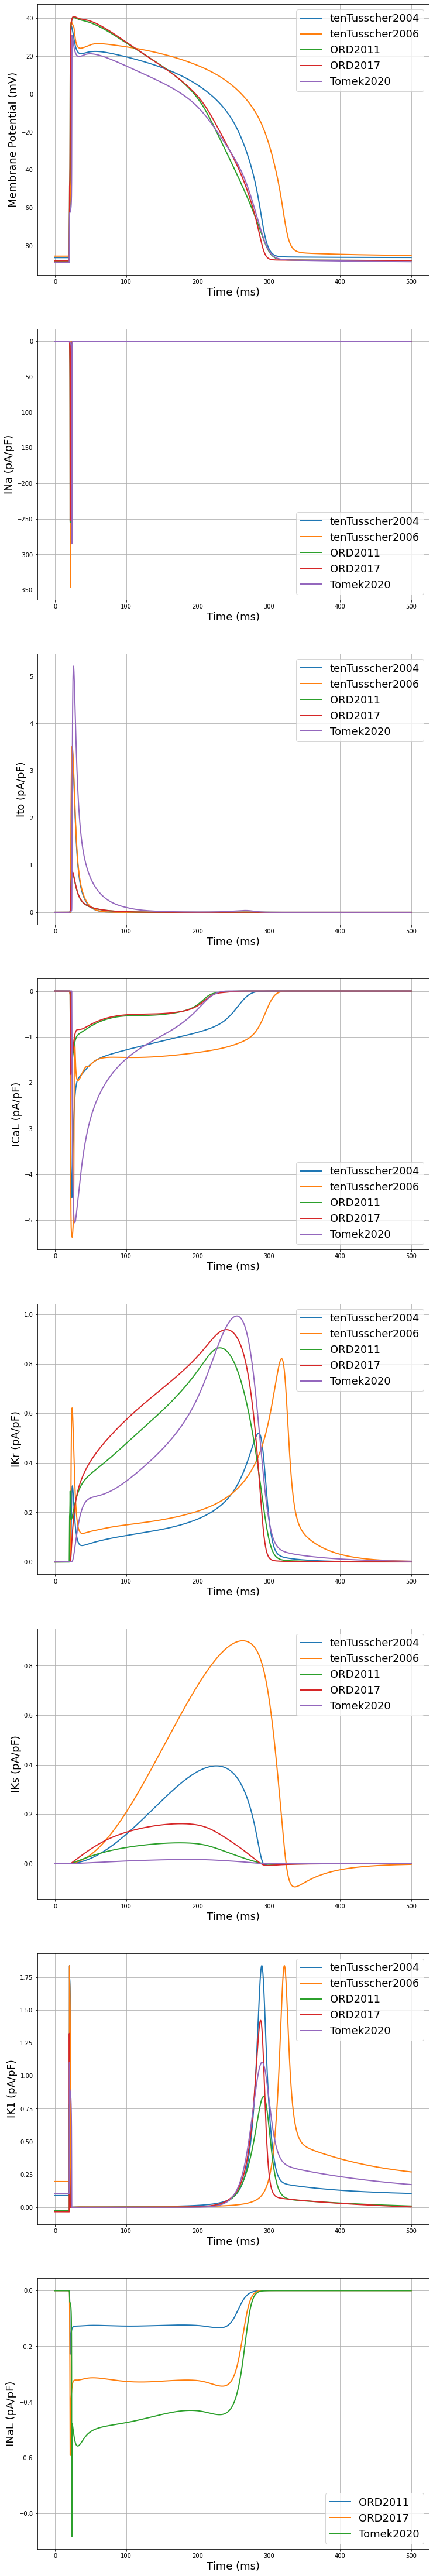

--- 2.8018147945404053 seconds ---


In [10]:
'''
Plot
'''
start_time = time.time()

fig, ax = plt.subplots(8,1, figsize=(12, 80))    
ax[0].plot( np.zeros(args.end_time), linewidth=1, color='k')      
# fig.suptitle(f"{model_name}-{cell_types[args.cell_typeNo]}", fontsize=20)
for model_name, m in models.items():
    # print(model_name)                    
    # ax[0].set_title(f"{model_name}-{cell_types[args.cell_typeNo]}", fontsize=20)
    # ax.set_xlim(bdf_m.times.min(), bdf_m.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax[0].set_ylabel('Membrane Potential (mV)', fontsize=18)  
    ax[0].set_xlabel('Time (ms)', fontsize=18)       
    ax[0].plot( m.time, m.V, label=model_name, linewidth=2)            
    # textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(GNa/g_fc[0], \
    #             GNaL/g_fc[1], Gto/g_fc[2], PCa/g_fc[3], GKr/g_fc[4], GKs/g_fc[5], GK1/g_fc[6], Gf/g_fc[7])
    # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    #     ax.text(0.67, 0.60, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)    
    #     fig1 = plt.gcf()
    ax[0].legend(fontsize=18)
    ax[0].grid()
    
    for i, [ion_name, Iion] in enumerate(m.I.items()):
        # ax[i+1].set_title(f"{model_name}-{cell_types[args.cell_typeNo]}", fontsize=20)
        # ax.set_xlim(bdf_m.times.min(), bdf_m.times.max())
        # ax.set_ylim(ylim[0], ylim[1])
        
        ax[i+1].set_ylabel(f"{ion_name} (pA/pF)", fontsize=18)  
        ax[i+1].set_xlabel('Time (ms)', fontsize=18)       
        ax[i+1].plot( m.time, Iion, label=model_name, linewidth=2)         
        # textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(GNa/g_fc[0], \
        #             GNaL/g_fc[1], Gto/g_fc[2], PCa/g_fc[3], GKr/g_fc[4], GKs/g_fc[5], GK1/g_fc[6], Gf/g_fc[7])
        # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        # place a text box in upper left in axes coords
        #     ax.text(0.67, 0.60, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)    
        #     fig1 = plt.gcf()
        ax[i+1].legend(fontsize=18)
        ax[i+1].grid()
        
plt.show()
fig.savefig(os.path.join(result_dir, f"{args.cell_types[args.cell_typeNo]}.jpg"), dpi=300)    

print("--- %s seconds ---"%(time.time()-start_time))

tenTusscher2004


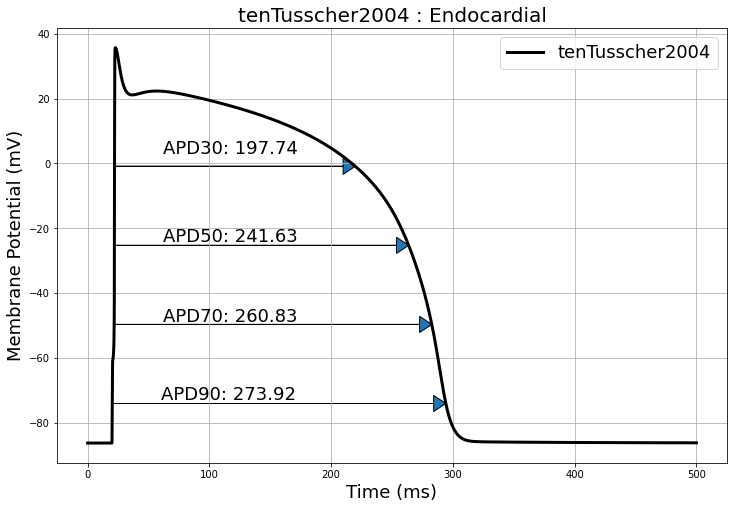

----------------------------------------------------------------------------------------------------
tenTusscher2006


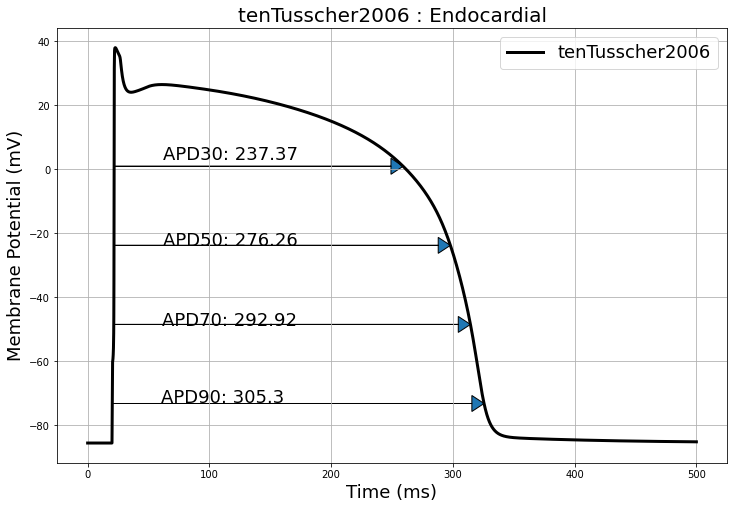

----------------------------------------------------------------------------------------------------
ORD2011


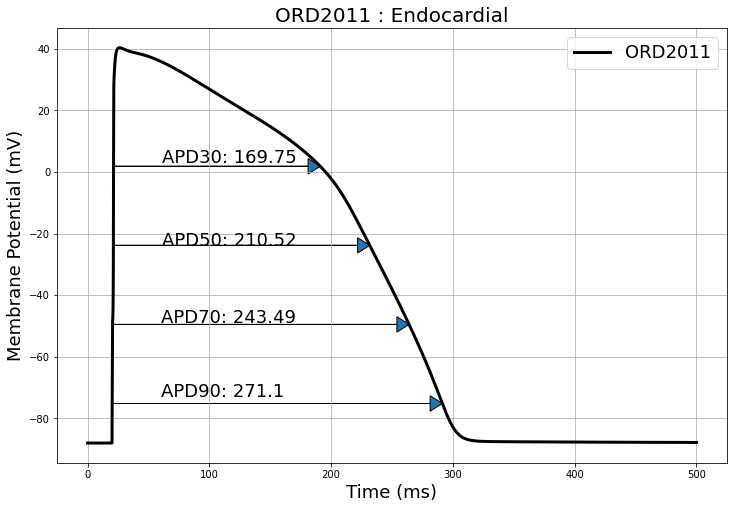

----------------------------------------------------------------------------------------------------
ORD2017


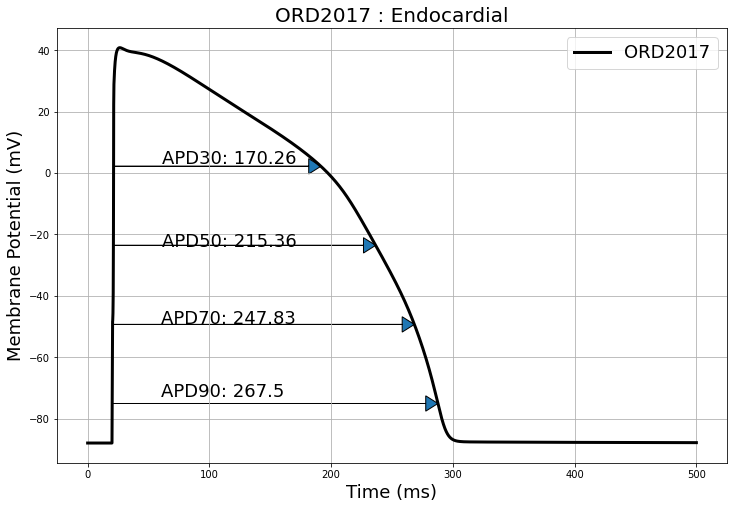

----------------------------------------------------------------------------------------------------
Tomek2020


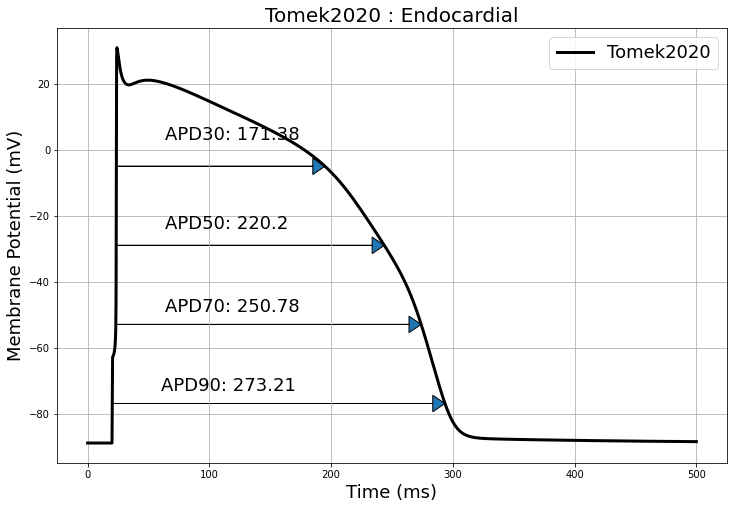

----------------------------------------------------------------------------------------------------
--- 1.4894273281097412 seconds ---


In [11]:
'''
Plot
'''
start_time = time.time()

for model_name, m in models.items():
    print(model_name)        
    apd30 = m.apd[30]
    apd50 = m.apd[50]
    apd70 = m.apd[70]
    apd90 = m.apd[90]
    fig, ax = plt.subplots(1,1, figsize=(12,8))    
    # fig.suptitle(sim_ohara2017.name, fontsize=14)
    ax.set_title(f"{model_name} : {args.cell_types[args.cell_typeNo]}", fontsize=20)
    # ax.set_xlim(bdf_m.times.min(), bdf_m.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax.set_ylabel('Membrane Potential (mV)', fontsize=18)  
    ax.set_xlabel('Time (ms)', fontsize=18)       

    ax.plot( m.time, m.V, label=model_name, linewidth=3, color='k')      
#     ax.arrow(apd50['start'], apd50['vt'], apd50['duration'], 0, head_width=5, head_length=10, length_includes_head=True)
#     ax.text(apd50['start']+40, -40, str(apd50['duration']), fontsize=18)
    ax.arrow(apd30['start'], apd30['vt'], apd30['duration'], 0, head_width=5, head_length=10, length_includes_head=True)
    ax.text(apd30['start']+40, 3, "APD30: "+str(round(apd30['duration'],2)), fontsize=18)
    
    ax.arrow(apd50['start'], apd50['vt'], apd50['duration'], 0, head_width=5, head_length=10, length_includes_head=True)
    ax.text(apd50['start']+40, -24, "APD50: "+str(round(apd50['duration'],2)), fontsize=18)
    
    ax.arrow(apd70['start'], apd70['vt'], apd70['duration'], 0, head_width=5, head_length=10, length_includes_head=True)
    ax.text(apd70['start']+40, -49, "APD70: "+str(round(apd70['duration'],2)), fontsize=18)
    
    ax.arrow(apd90['start'], apd90['vt'], apd90['duration'], 0, head_width=5, head_length=10, length_includes_head=True)
    ax.text(apd90['start']+40, -73, "APD90: "+str(round(apd90['duration'],2)), fontsize=18)
    # textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(GNa/g_fc[0], \
    #             GNaL/g_fc[1], Gto/g_fc[2], PCa/g_fc[3], GKr/g_fc[4], GKs/g_fc[5], GK1/g_fc[6], Gf/g_fc[7])
    # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    #     ax.text(0.67, 0.60, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)    
    #     fig1 = plt.gcf()
    ax.legend(fontsize=18)
    ax.grid()
    plt.show()
    fig.savefig(os.path.join(result_dir, f"{model_name}_{args.cell_types[args.cell_typeNo]}-APD.jpg"), dpi=300)    
    print('-'*100)
print("--- %s seconds ---"%(time.time()-start_time))

In [12]:
print("Complete")

Complete
